In [1]:
import time
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display
import moviepy.editor as mpy

from dataset import Dataset

Camera position mean & std:
[ -1.9723758  -11.407406     0.36299774] [10.950828   5.4356313 11.073948 ]


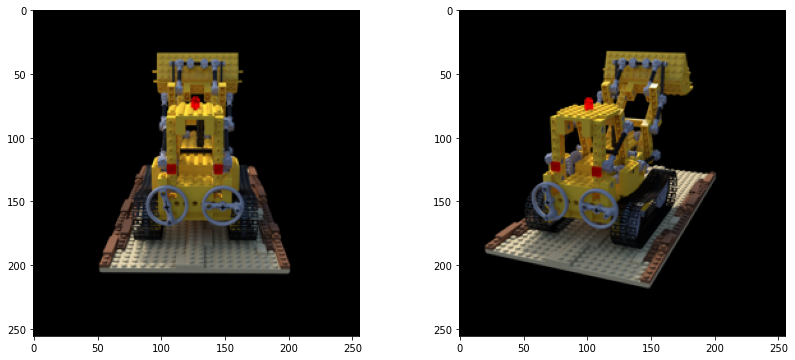

In [2]:
data = Dataset('../public/data/lego', 'blender')
H, W = data.H, data.W

plt.figure(figsize=(14, 6))
plt.subplot(121)
plt.imshow(data.images[0].permute(1,2,0))
plt.subplot(122)
plt.imshow(data.images[1].permute(1,2,0))
plt.show()

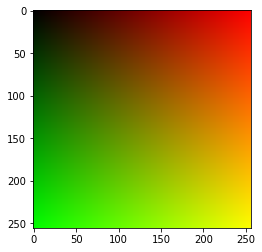

In [4]:
y = data.images[:2].permute(0, 2, 3, 1).reshape(-1, 3).cuda()

i, j = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
x1 = torch.stack([i / W, j / H, torch.zeros_like(i)], dim=-1)
x2 = x1.clone()
x2[:,:,-1] = 1
x = torch.stack([x1, x2], dim=0).float().cuda()
x_flat = x.reshape(-1, 3)
plt.imshow(x_flat[:H*W].reshape(H, W, 3).cpu())

In [68]:
# https://davidlindell.com/publications/bacon

class Bacon(nn.Module):
    def __init__(self, res=256, n_layers=4, n_feats=256):
        super().__init__()
        
        if (n_layers < 2):
            n_layers = 2
            print("min layers: 2")
        
        self.res = res
        self.n_layers = n_layers
        self.n_feats = n_feats
        
        # omega/phi
        gwb = [nn.Linear(3, n_feats) \
                 for _ in range(n_layers + 1)]
        zwb = [nn.Linear(n_feats, n_feats) \
              for _ in range(n_layers)]
        ywb = [nn.Linear(n_feats, 3) \
               for _ in range(n_layers)]
        
        # max bandwidth
        total_B = np.pi * res
        # first 2 tb/8, rest set to sum to tb
        B = [total_B / 8] * 2
        B += [total_B * 3 / 4 / (n_layers - 1)] * (n_layers - 1)
        
        nn.init.uniform_(gwb[0].weight, -B[0], B[0])
        gwb[0].weight.requires_grad_(False)
        nn.init.uniform_(gwb[0].bias, -np.pi, np.pi)
        for i, (lg, lz, ly) in enumerate(zip(gwb[1:], zwb, ywb)):
            nn.init.uniform_(lg.weight, -B[i + 1], B[i + 1])
            lg.weight.requires_grad_(False)
            nn.init.uniform_(lg.bias, -np.pi, np.pi)
            nn.init.uniform_(lz.weight, -np.sqrt(6/n_feats),
                             np.sqrt(6/n_feats))
        
        self.gwb = nn.ModuleList(gwb)
        self.zwb = nn.ModuleList(zwb)
        self.ywb = nn.ModuleList(ywb)
    
    def forward(self, x):
        x = x.clone()
        x[:, -1] /= self.res / 4
        y = []
        z = self.gwb[0](x).sin()
        for i in range(self.n_layers):
            g = self.gwb[i + 1](x).sin()
            z = g * self.zwb[i](z)
            y.append(self.ywb[i](z))
        
        return y

model = Bacon().cuda()

mse = nn.MSELoss()
def loss_fn(output, target):
    return sum([mse(v, target) for v in output]) / len(output)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

3000/3000
36s - eta 0s


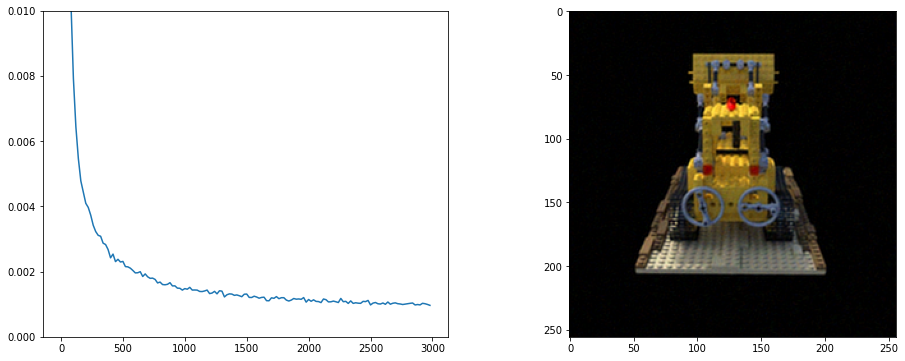

In [69]:
train_st = time.time()
time_to_s = lambda t: (f'{int(t / 60)}m' if t >= 60 else '') + f'{int(t) % 60}s'

n_iter = int(3e3)
batch_size = int(1e4)

for i in range(n_iter):
    sel = np.random.choice(x_flat.shape[0], batch_size)
    pred = model(x_flat[sel])
    loss = loss_fn(pred, y[sel])
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if (i + 1) % 20 == 0:
        losses.append(loss.item())
    if (i + 1) % 500 == 0:
        display.clear_output(wait=True)
        print(f'{i+1}/{n_iter}')
        time_passed = time.time() - train_st
        eta = time_passed * (n_iter - i) / i
        print(f'{time_to_s(time_passed)} - eta {time_to_s(eta)}')
        plt.figure(figsize=(16, 6))
        plt.subplot(121)
        plt.plot(np.arange(len(losses)) * 20, losses)
        plt.ylim([0, 0.01])
        plt.subplot(122)
        with torch.no_grad():
            pred = model(x_flat[:H*W])[-1]
            plt.imshow(pred.clip(0,1).reshape(H, W, 3).cpu())
        plt.show()

In [72]:
saw = lambda x: 1 - abs(x % 2 - 1)
ease_quad = lambda x: 2 * x**2 if x < 0.5 else 1 - (-2 * x + 2)**2 / 2

def make_frame(t):
    t = ease_quad(saw(t))
    bx = (x[0] * (1 - t) + x[1] * t).reshape(-1, 3)
    bx = bx.clone()
    bx[:,:2] *= 3
    bx[:,:2] -= 1
    pred = model(bx)[0]
    img = pred.clip(0, 1).reshape(H, W, 3)
    return img.multiply(255).int().cpu().numpy()

clip = mpy.VideoClip(make_frame, duration=2)
clip.write_videofile('videos/bacon.mp4', fps=24)

display.clear_output()
display.display(display.HTML('<video src="videos/bacon.mp4" controls=true autoplay=true loop=true />'))